In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import regression_funs as rfu


## constants and functions

In [3]:

PATH_TO_FILE = '../data_in/flexpart-mosaic-data_alias/AIRTRACER_100m.nc'

PATH_TO_SO2 = '../data_in/flexpart-mosaic-data_alias/MSAQSO2L4_2005-2018_v01-04_20190314.h5'

PATH_TO_ST = '../data_in/ciapitof_masked_filtered.csv'

PATH_TO_BC = '../data_in/black_carbon_channel6_masked_5min.csv'

PATH_200_CLUS = '../data_out/cluster1000.nc'

LA = 'lat'
LO = 'lon'
TI = 'time'
AG = 'age'
AT = 'AIRTRACER'
L = 'lab'
CM = 'tab20'

SA = 'sa'
MSA = 'msa'
IA = 'ia'

BC = 'bc_masked_ngm3'

LBC = 'log(bc)'

LSA = 'log10(sa)'
LMSA = 'log10(msa)'
LIA = 'log10(ia)'

COLS = [SA, MSA, IA]
LCOLS = [LSA, LMSA, LIA]

DATA_OUT = '../data_out'

COL = plt.get_cmap('Dark2')

DC = {
    SA  : COL(0),
    MSA : COL(1),
    IA  : COL(2),
    LSA : COL(0),
    LMSA: COL(1),
    LIA : COL(2),
    BC  : COL(3),
    LBC : COL(3)
}

In [4]:
df = pd.read_csv(PATH_TO_BC, index_col=0, parse_dates=True)

In [5]:
df = df[df[BC]>0]

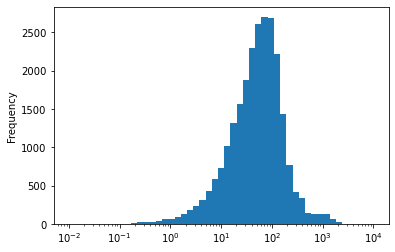

In [6]:
df[BC].plot.hist(bins=np.geomspace(.01,10000))
plt.gca().set_xscale('log')

In [7]:


for l, c in zip([BC], [LBC]):
    df[c] = np.log10(df[l])

# distributions


lets find what kind of dist. do we have. They seem to be log dists.

In [8]:
df

,bc_masked_ngm3,log(bc)
time,,
2019-10-01 00:00:00,794.965118,2.900348
2019-10-01 00:10:00,54.701448,1.737999
2019-10-01 00:15:00,30.670707,1.486724
2019-10-01 00:30:00,46.887946,1.671061
2019-10-01 00:35:00,2.702929,0.431835
...,...,...
2020-09-29 12:00:00,31.747037,1.501703
2020-09-29 12:10:00,36.629798,1.563835
2020-09-29 12:15:00,20.219057,1.305761


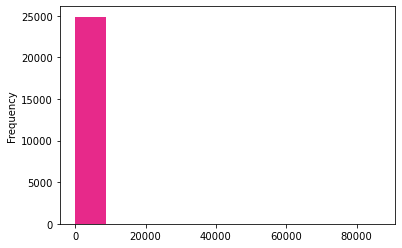

In [9]:
for c in [BC]:
    df[c].plot.hist(color=DC[c])

Text(0.5, 0, 'log10')

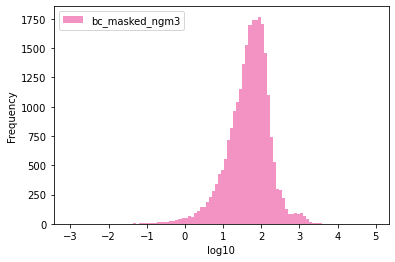

In [10]:
for c in [BC]:
    np.log10(df[c]).plot.hist(alpha=.5, bins=100, label=c, color=DC[c])
ax = plt.gca()
ax.legend()
ax.set_xlabel('log10')

# timeseries of the trace gases

# open and merge flex 200 clusters

In [11]:
ds = xr.open_dataset(PATH_200_CLUS)

In [12]:
dsf = ds.groupby(L).sum().to_dataframe()[AT].unstack(L)

q0, q1 = np.quantile(dsf.values.flatten(), [.01, .99])



# f, axs = plt.subplots(10, 20, sharex=True, sharey=True, figsize=(20, 20))
# axf = axs.flatten()

# for i, ax in zip(dsf.columns, axf):
#     ax.hist(np.log10(dsf[i] + q0), bins=np.linspace(np.log10(q0), np.log10(q1 + q0), 20))
#     ax.set_xlabel('')
#     ax.set_ylabel('')

In [13]:
dsfn = dsf / dsf.mean()

In [14]:
q0, q1 = dsfn.stack().quantile([.01, .99])

In [15]:
# f, axs = plt.subplots(10, 20, sharex=True, sharey=True, figsize=(20, 20))
# axf = axs.flatten()

# for i, ax in zip(dsfn.columns, axf):
#     ax.hist(dsfn[i], bins=np.linspace(q0, q1, 20))
#     ax.set_xlabel('')
#     ax.set_ylabel('')

In [16]:
df1 = df

In [17]:
df2 = df1.resample('3H').median()

In [18]:
dm = pd.merge(df2, dsf, left_index=True, right_index=True, how='inner', validate="1:1")

# Invers modeling elastic NET

0.0028022033565213633 0.5


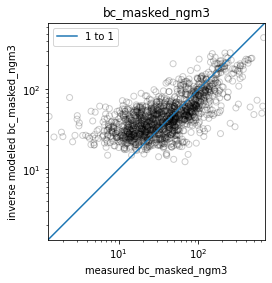

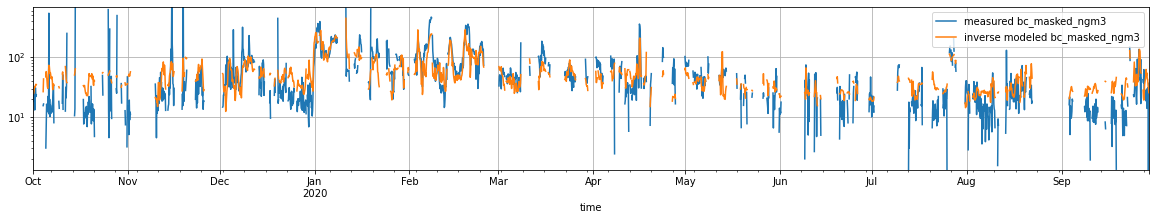

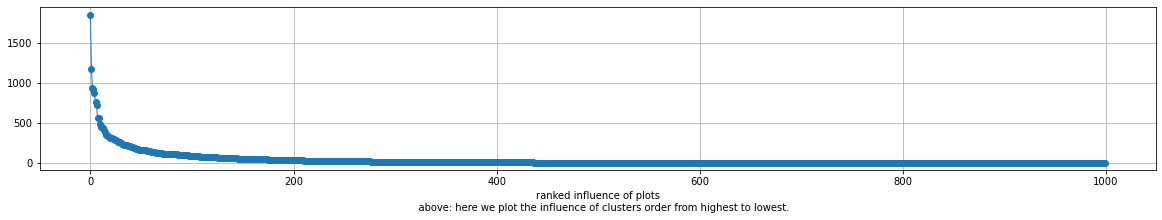

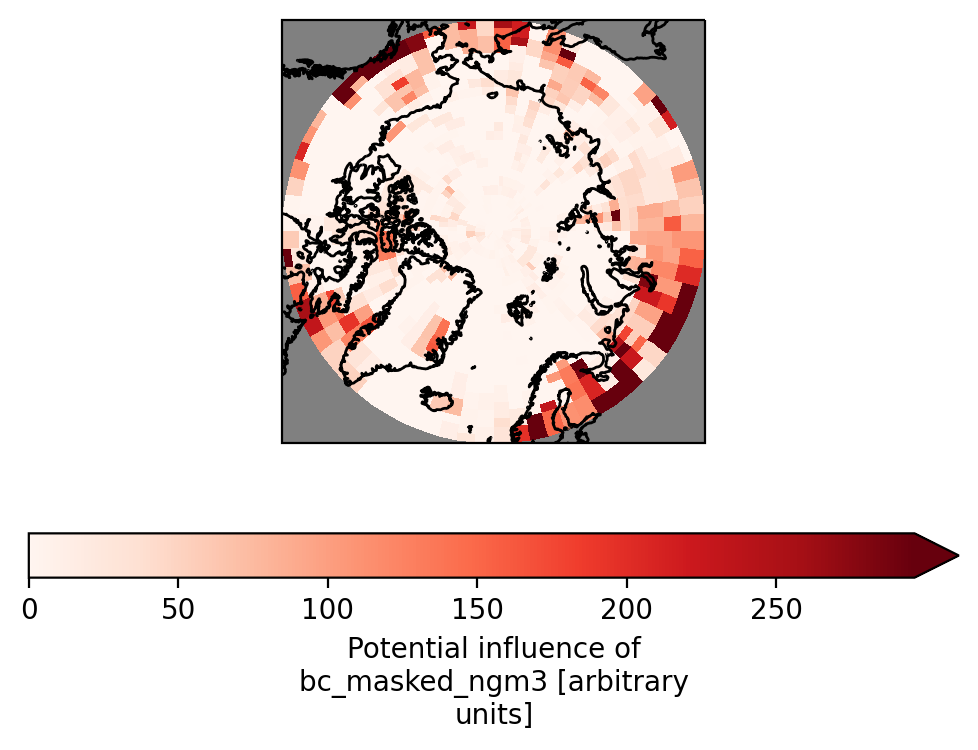

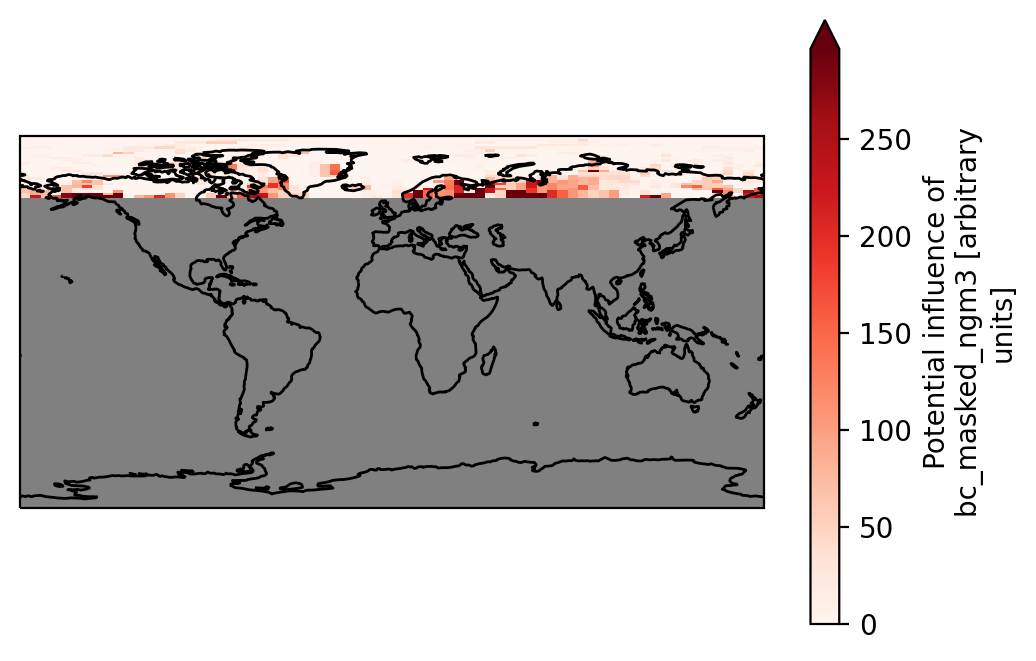

In [19]:
# for PAR in [SA,MSA,IA]:
for PAR in [BC]:
    pred, cdf, y, yn, dp = rfu.elastic_net_reg(dsf, dm, PAR)
    MEA = f'measured {PAR}'
    MOD = f'inverse modeled {PAR}'
    rfu.scatter_plot(y, yn, pred, MEA, MOD, PAR)
    rfu.mea_vs_mod_plot(y, yn, dp, pred, MEA, MOD)
    rfu.rank_cluster_inf(cdf)
    dd2 = rfu.get_plot_inf(cdf, L, ds,PAR)
    rfu.plot_map(dd2)
    rfu.plot_map_rect(dd2)

In [20]:
PAR = BC
cdf.sort_values(ascending=False)

lab
999    1855.760742
976    1178.645142
998     931.676025
970     929.211792
997     871.615417
          ...     
430       0.000000
431       0.000000
433       0.000000
436       0.000000
500       0.000000
Length: 1000, dtype: float32

In [21]:
import funs as fu

In [22]:
d5 = fu.get_bounds(LA, ds[AT])
d6 = fu.get_bounds(LO, d5)

df = d6[L].to_dataframe()

df1 = df.loc[:, ~df.columns.duplicated()]

G = 'geometry'

In [23]:
df1[G] = df.apply(fu.get_pol, axis=1)

In [24]:
import geopandas
dg = geopandas.GeoDataFrame(df1).reset_index()

dg1 = dg[[L, G]].dissolve(by=L)

In [25]:
cdf.name = 'infl'

In [26]:
df2 = pd.merge(dg1,cdf,left_index=True,right_index=True)

In [27]:
df3 = df2.sort_values('infl',ascending=False).iloc[:20]

In [28]:
df3['infl']

lab
999    1855.760742
976    1178.645142
998     931.676025
970     929.211792
997     871.615417
897     757.363220
966     723.488098
887     556.885498
995     556.468994
971     491.482452
992     451.758240
919     450.358887
972     431.043854
939     412.163910
954     386.610016
960     347.381287
712     344.779816
891     330.226990
719     326.099518
929     315.890442
Name: infl, dtype: float32

In [29]:
dm1 = dm[df3.index]

In [30]:
dm2 = dm1/dm1.sum()
dm2 = (dm1 * df3['infl'])/100000

In [31]:
cmap = plt.get_cmap('tab20')

In [32]:
co = dm2.columns

In [33]:
q1,q2=dm2.stack().quantile([.001,.999])

/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


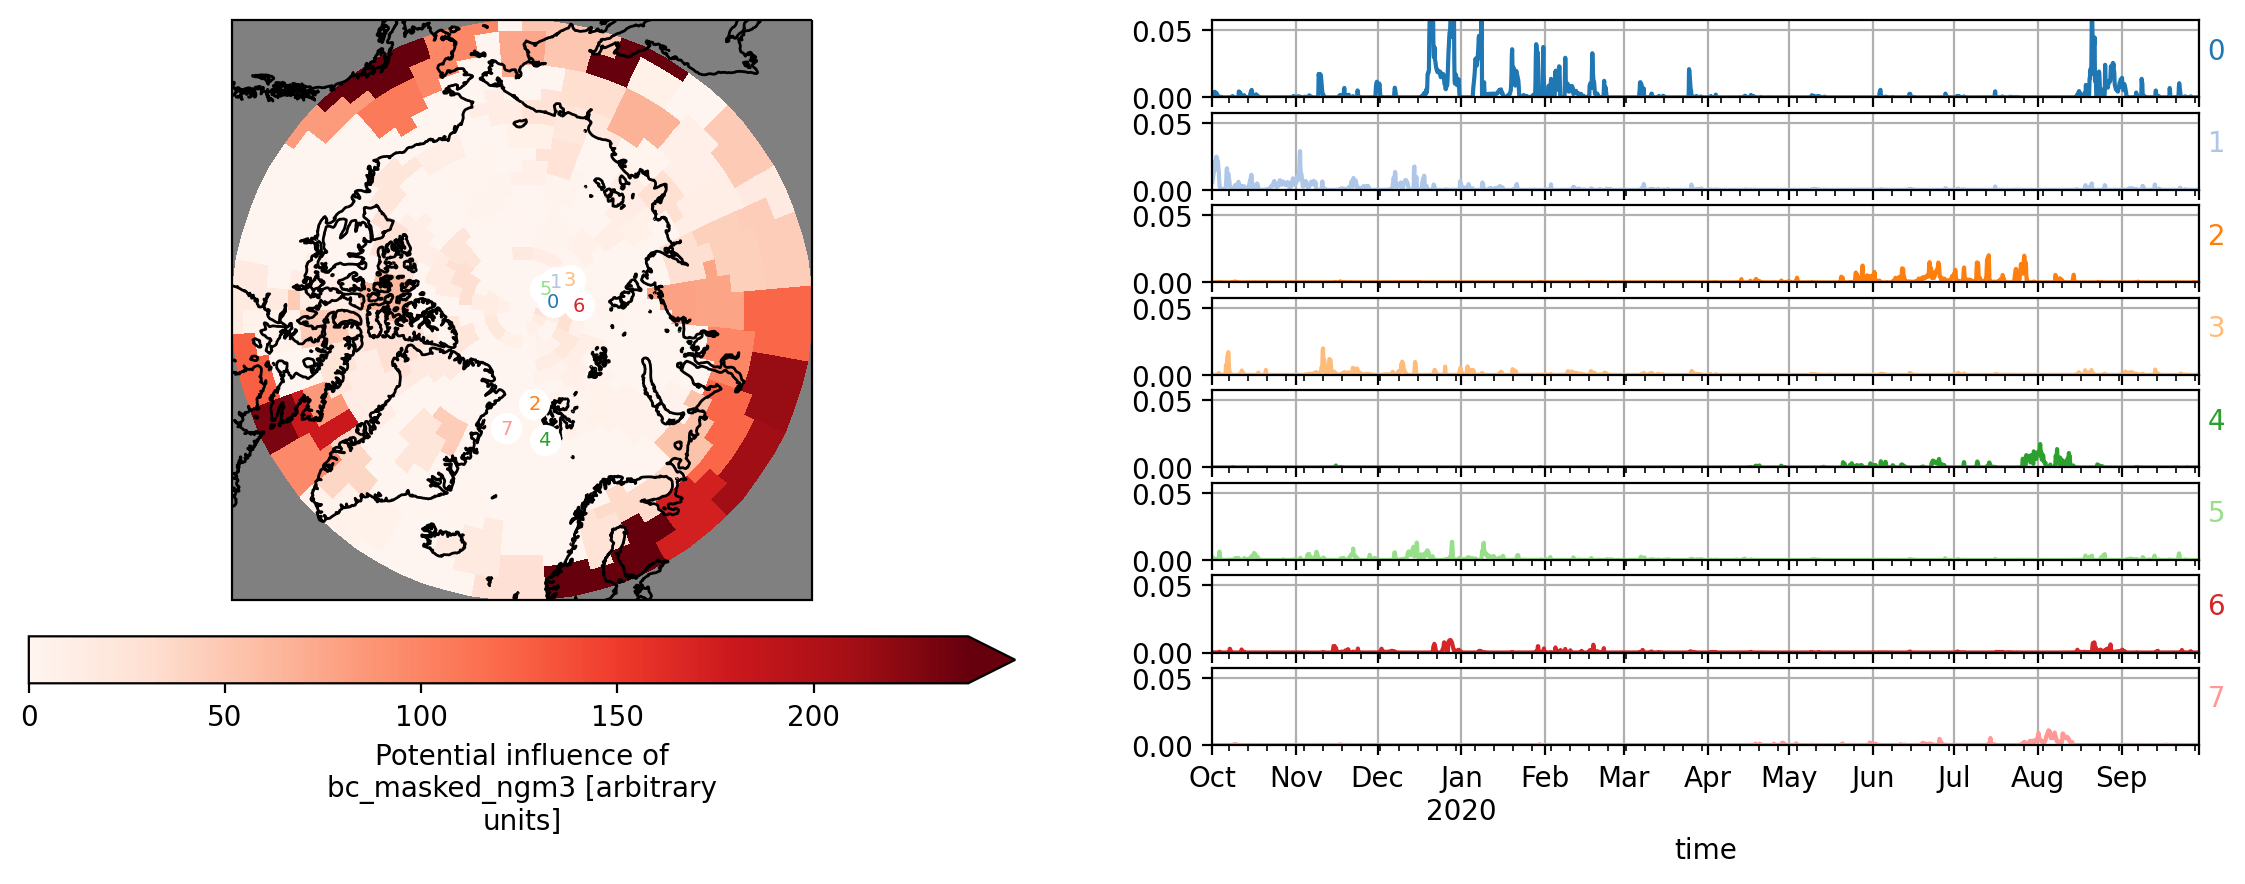

In [146]:
lco = len(co)

f = plt.figure(constrained_layout=True,figsize=(2*7,lco*.6),dpi=200)

import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(lco,2)




# f,axs=plt.subplots(lco,dpi=200,sharex=True,sharey=True,figsize=(7,lco*.6))


ax0 = None
for i,c in enumerate(co):
    ax = f.add_subplot(gs[i, 1],sharex=ax0)
    if i == 0: ax0 = ax
    (dm2[c]).plot(c=cmap(i),ax=ax)
    ax.text(1,.5,f' {i}',transform=ax.transAxes,c=cmap(i))
    ax.grid()
    ax.set_ylim(0,q2*1.1)
# ax=plt.gca()
# ax.set_yscale('log')
# ax.set_ylim(q1,q2)
# ax.legend(bbox_to_anchor=(1,1))


import cartopy.crs as ccrs
ax = f.add_subplot(gs[:,0],projection=ccrs.Orthographic(0, 90), facecolor="gray")
rfu.plot_map(dd2,ax=ax)
# ax=plt.gca()
for i,c in enumerate(co):
    p =df3.representative_point()[c]
    ax.scatter( p.x,p.y,transform=ccrs.PlateCarree(),c='w',s=105,alpha=1,zorder=19)
    ax.text( p.x,p.y,i,transform=ccrs.PlateCarree(),c=cmap(i),va='center',ha='center',fontsize=7,zorder = 20)



In [147]:
    from sklearn.linear_model import ElasticNetCV,ElasticNet

    c200 = dsf.columns

    X = dm[c200]

    xn = np.sqrt((X ** 2).sum())

    XX = X.divide(xn, axis=1)


    y = dm[PAR]
    yn = y.notna()
    y = y[yn]
    ii = [.1, .5, .7, .9, .95, .99, 1]
    regr = ElasticNetCV(cv=5, random_state=0, positive=True, l1_ratio=ii, fit_intercept=False)
#     regr = ElasticNet( random_state=0, positive=True, l1_ratio=ii, fit_intercept=False)

    regr.fit(XX[yn], y[yn])

    pred = regr.predict(XX[yn])
    dp = pd.Series(pred, index=y[yn].index)
    cdf = pd.Series(regr.coef_, index=XX.columns)
    cdf = cdf / xn

In [148]:
regr = ElasticNetCV(alphas=.5,cv=5, random_state=0, positive=True, l1_ratio=ii, fit_intercept=False)

In [149]:
ccs = {}
r = {}
for a in np.geomspace(.01,1,201):
    from sklearn.linear_model import ElasticNetCV,ElasticNet

    c200 = dsf.columns

    X = dm[c200]

    xn = np.sqrt((X ** 2).sum())

    XX = X.divide(xn, axis=1)


    y = dm[PAR]
    yn = y.notna()
    y = y[yn]
    ii = [.1, .5, .7, .9, .95, .99, 1]
#     
    regr = ElasticNet(alpha=a, random_state=0, positive=True, l1_ratio=1, fit_intercept=False)

    regr.fit(XX[yn], y[yn])

    pred = regr.predict(XX[yn])
    dp = pd.Series(pred, index=y[yn].index)
    cdf = pd.Series(regr.coef_, index=XX.columns)
    cdf = cdf
    cdf = cdf/cdf.sum()
    ccs[a]=cdf
    r[a]=regr.score(XX[yn], y[yn])

In [150]:
regr = ElasticNetCV(cv=5, random_state=0, positive=True, l1_ratio=ii, fit_intercept=False)
regr.fit(XX[yn], y[yn])

ElasticNetCV(cv=5, fit_intercept=False,
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], positive=True,
             random_state=0)

In [151]:
regr.alpha_

0.0033329295889562532

<AxesSubplot:>

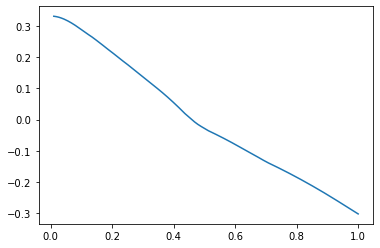

In [152]:
pd.Series(r).plot()

In [153]:
ddd = pd.DataFrame(ccs).T

In [154]:
ddd

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0.010000,0.0,0.018322,0.0,0.0,0.0,0.007734,0.0,0.0,0.002148,0.0,...,0.0,0.003405,0.0,0.027290,0.017325,0.0,0.0,0.0,0.0,0.005904
0.010233,0.0,0.018319,0.0,0.0,0.0,0.007729,0.0,0.0,0.002141,0.0,...,0.0,0.003454,0.0,0.027298,0.017352,0.0,0.0,0.0,0.0,0.005963
0.010471,0.0,0.018316,0.0,0.0,0.0,0.007723,0.0,0.0,0.002133,0.0,...,0.0,0.003504,0.0,0.027305,0.017380,0.0,0.0,0.0,0.0,0.006024
0.010715,0.0,0.018313,0.0,0.0,0.0,0.007718,0.0,0.0,0.002126,0.0,...,0.0,0.003556,0.0,0.027313,0.017409,0.0,0.0,0.0,0.0,0.006087
0.010965,0.0,0.018309,0.0,0.0,0.0,0.007712,0.0,0.0,0.002118,0.0,...,0.0,0.003609,0.0,0.027320,0.017438,0.0,0.0,0.0,0.0,0.006152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.912011,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
0.933254,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
0.954993,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
0.977237,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000


In [155]:
l = []
for a,r in ddd.iloc[::-1].iloc[::].iterrows():
    
    rr = r[~r.index.isin(l)]

    try:
        iii = rr.idxmax()
    #     print(iii)
        if rr.sum() == 0:
            continue
#             print(a)
        l.append(iii)
    except:
        break
    
    

In [156]:
len(l)

62

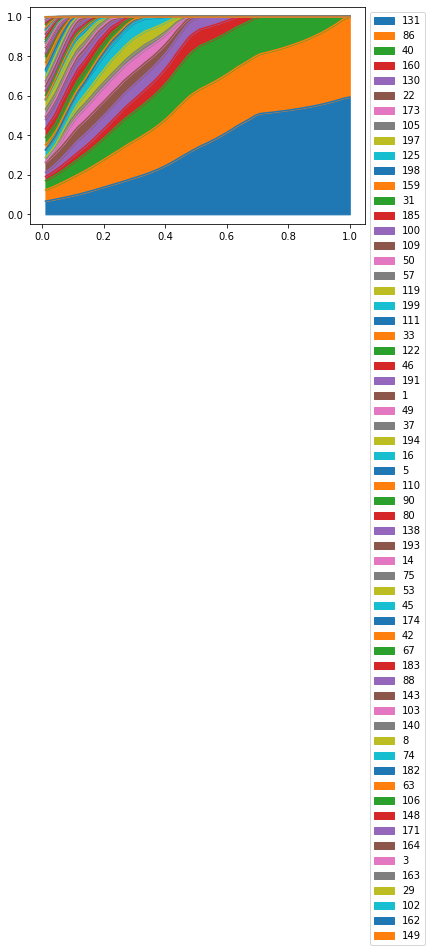

In [157]:
ddd[l].plot.area()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1,1))
# ax.legend().remove()

In [158]:
rem = set(ddd.columns)-set(l)
l1 = [*l,*rem]

In [159]:
dd = pd.Series(l1).reset_index().set_index(0)['index'].to_dict()

In [160]:
ds2 = ds[L].to_series().replace(dd).to_xarray()

In [161]:
ds

<xarray.Dataset>
Dimensions:    (lon: 72, lat: 24, time: 3021)
Coordinates:
  * lon        (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * lat        (lat) float64 60.62 61.88 63.12 64.38 ... 85.62 86.88 88.12 89.38
  * time       (time) datetime64[ns] 2019-09-20T09:00:00 ... 2020-10-01T21:00:00
    lab        (lat, lon) int64 162 193 193 173 173 173 ... 123 123 123 123 144
Data variables:
    AIRTRACER  (time, lat, lon) float32 0.0004269 0.0001852 ... 0.0002132

In [162]:
q1,q2 = ds[AT].sum('time').quantile([.01,.5])

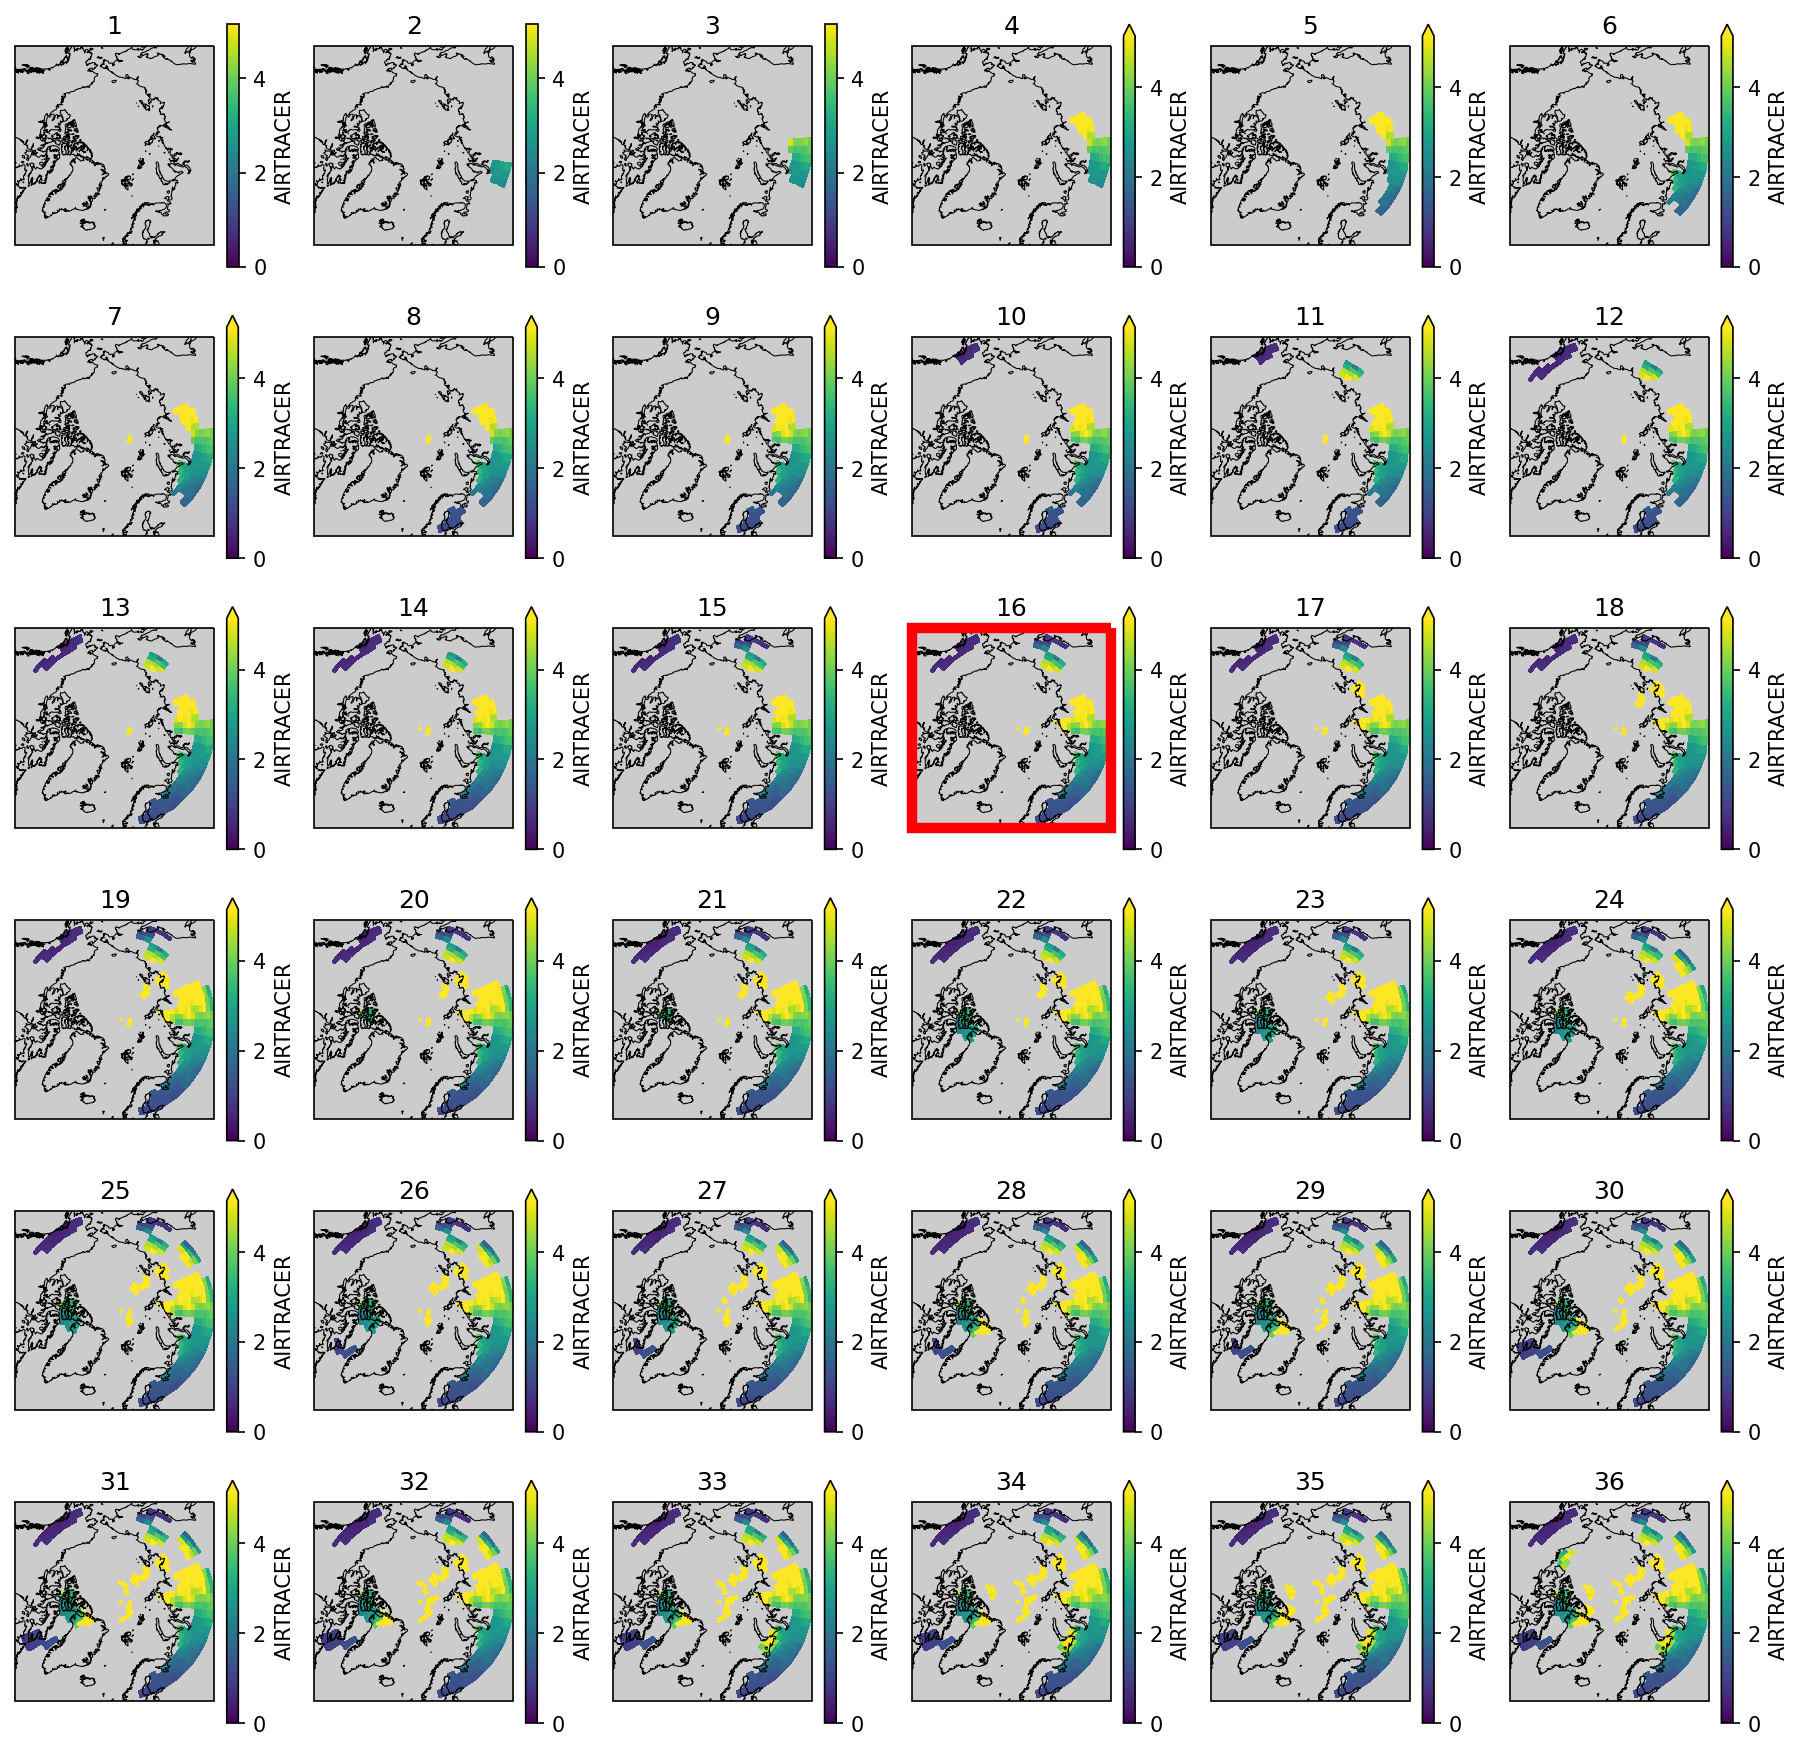

In [166]:
AA=15
import matplotlib as mpl
dic = dict(projection=ccrs.Orthographic(0, 90), facecolor=".8")


f, axs = plt.subplots(6,6,subplot_kw=dic, sharex=True,sharey=True,figsize=(15,15),dpi=150)
for i in range(36):
    ax = axs.flatten()[i]
    p=ds[AT].sum('time').where(ds2<i).plot(
        # subplot_kws=dic,
        transform=ccrs.PlateCarree(),
    #     norm=mpl.colors.LogNorm(vmin, vmax),
    #     robust=True,
        cmap='viridis',
        vmax=q2,
        vmin=0,
        ax=ax
        
    )
    ax.set_title(i+1)
    if i ==AA:    
        for spine in ax.spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(5)
    p.axes.coastlines(lw=.5)



In [167]:
ds16 = ds[AT].sum('time').where(ds2<i)

In [168]:
ds16.to_dataframe()

lab  AIRTRACER
lat    lon                  
60.625 2.5    162        NaN
       7.5    193        NaN
       12.5   193        NaN
       17.5   173   1.107274
       22.5   173   1.101493
...           ...        ...
89.375 337.5  123        NaN
       342.5  123        NaN
       347.5  123        NaN
       352.5  123        NaN
       357.5  144        NaN

[1728 rows x 2 columns]

In [169]:
import geopandas

d5 = fu.get_bounds(LA, ds[AT])
d6 = fu.get_bounds(LO, d5)

df = d6[L].to_dataframe()

df1 = df.loc[:, ~df.columns.duplicated()]

G = 'geometry'

df1[G] = df.apply(fu.get_pol, axis=1)


dg = geopandas.GeoDataFrame(df1).reset_index()

dg1 = dg[[L, G]].dissolve(by=L)

<AxesSubplot:>

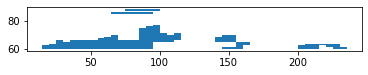

In [170]:
dg2=dg1[dg1.index.isin(l[:AA])]
dg2.plot()

In [171]:
dg3 = dg2.set_crs(ccrs.PlateCarree()).to_crs(ccrs.Orthographic(0, 90))

In [172]:
mpol = dg3.unary_union

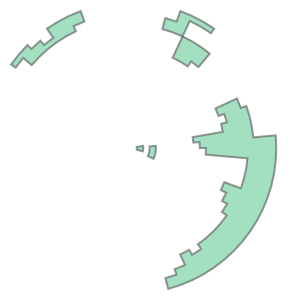

In [173]:
mpol

In [174]:
pols = list(mpol)

In [175]:
pols

In [176]:
pols_se = geopandas.GeoDataFrame(geometry=pols)

In [177]:
pols_se = pols_se[:]

In [178]:
pols_se['area'] = pols_se.area

In [179]:
ps1 = pols_se.sort_values('area')[::-1].reset_index(drop=True)

In [180]:
ps2=ps1.set_crs(ccrs.Orthographic(0, 90)).to_crs(ccrs.PlateCarree())

<AxesSubplot:>

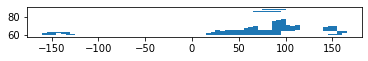

In [181]:
ps2['geometry'].plot()

In [182]:
from shapely import geometry

In [183]:
df= ds.to_dataframe()

In [184]:
i

35

In [185]:
dg3 = dg2.set_crs(ccrs.PlateCarree()).to_crs(ccrs.Orthographic(0, 90))

In [186]:
iv = {}
for i,v in dg3.representative_point().items():
    nn = ps1[ps1.contains(v)]
    n = nn.index[0]
    iv[i]=n

In [187]:
iv

{22: 4,
 31: 5,
 40: 0,
 86: 0,
 100: 0,
 105: 0,
 125: 2,
 130: 0,
 131: 0,
 159: 0,
 160: 0,
 173: 0,
 185: 3,
 197: 1,
 198: 1}

In [188]:
dss =ds.to_dataframe()

In [189]:
dss

lab  AIRTRACER
lon   lat    time                               
2.5   60.625 2019-09-20 09:00:00  162   0.000427
             2019-09-20 12:00:00  162   0.000354
             2019-09-20 15:00:00  162   0.000287
             2019-09-20 18:00:00  162   0.000290
             2019-09-20 21:00:00  162   0.000438
...                               ...        ...
357.5 89.375 2020-10-01 09:00:00  144   0.000007
             2020-10-01 12:00:00  144   0.000006
             2020-10-01 15:00:00  144   0.000010
             2020-10-01 18:00:00  144   0.000009
             2020-10-01 21:00:00  144   0.000213

[5220288 rows x 2 columns]

In [190]:
dss1 = dss[dss[L].isin(l[:AA])].copy()

In [191]:

NL = 'nl'

In [192]:
dss1[NL] = dss1[L].replace(iv)

In [193]:
dss2 = dss1.where(dss1[NL]<9)

In [194]:
ndf = dss2.reset_index().groupby([NL,'time'])[AT].sum().unstack().T

In [195]:
ndf

nl,0,1,2,3,4,5
time,,,,,,
2019-09-20 09:00:00,0.016973,0.002981,0.023158,0.008750,0.000116,0.000063
2019-09-20 12:00:00,0.018283,0.003314,0.021207,0.009413,0.000110,0.000036
2019-09-20 15:00:00,0.017210,0.003932,0.015351,0.012087,0.000108,0.000040
2019-09-20 18:00:00,0.015923,0.003154,0.013071,0.013652,0.000112,0.000045
2019-09-20 21:00:00,0.017778,0.002159,0.016147,0.010147,0.000196,0.001747
...,...,...,...,...,...,...
2020-10-01 09:00:00,0.131634,0.002532,0.009724,0.000584,0.000844,0.000259
2020-10-01 12:00:00,0.151829,0.001988,0.010117,0.000525,0.000754,0.000245
2020-10-01 15:00:00,0.132432,0.001866,0.008108,0.000505,0.000863,0.000288


<AxesSubplot:xlabel='time'>

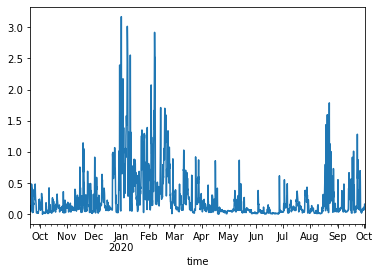

In [196]:
dss1.reset_index().groupby([NL,'time'])[AT].sum().unstack().sum().plot()

In [197]:
ndf.columns

Int64Index([0, 1, 2, 3, 4, 5], dtype='int64', name='nl')

In [198]:
ndm = ndf.copy()

In [199]:
ndm[PAR]=dm[PAR]

In [200]:
    from sklearn.linear_model import ElasticNetCV,ElasticNet, LinearRegression

    c200 = ndf.columns

    X = ndm[c200]

    xn = np.sqrt((X ** 2).sum())

    XX = X.divide(xn, axis=1)


    y = ndm[PAR]
    yn = y.notna()
    y = y[yn]
    ii = [.1, .5, .7, .9, .95, .99, 1]
#     
    regr = LinearRegression( positive=True, fit_intercept=False)

    regr.fit(XX[yn], y[yn])

    pred = regr.predict(XX[yn])
    dp = pd.Series(pred, index=y[yn].index)
    cdf = pd.Series(regr.coef_, index=XX.columns)
    cdf = cdf
#     cdf = cdf/cdf.sum()

    r2=regr.score(XX[yn], y[yn])

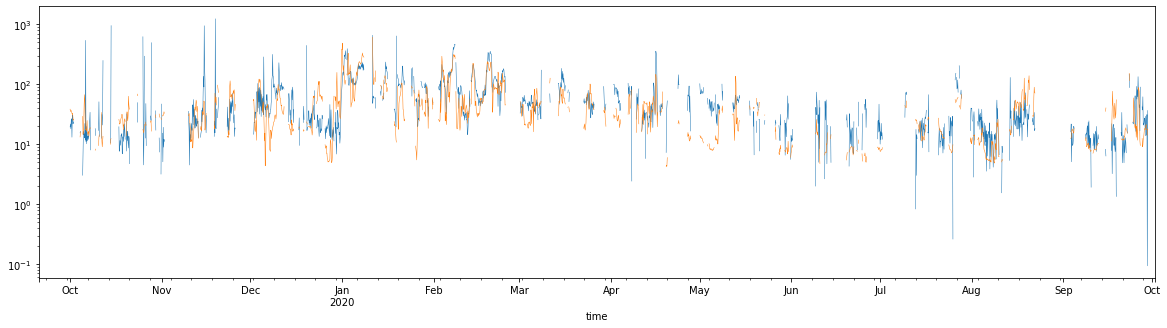

In [201]:
f,ax=plt.subplots(figsize=(20,5))
mod_ = (ndf/xn * cdf).sum(axis=1).where(yn)
ndm[PAR].where(yn).plot(label=f"{PAR} measured",lw=.5)
mod_.plot(label=f"{PAR} inverse modeled",lw=.5)
plt.gca().set_yscale('log')

In [202]:
dum = pd.DataFrame()
dum['mea'] = ndm[PAR].where(yn)
dum['mod'] = mod_

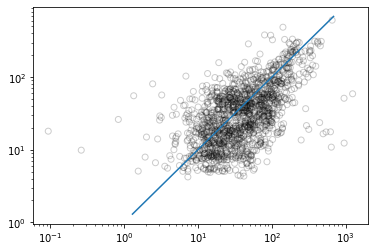

In [203]:
plt.scatter(dum['mea'],dum['mod'],alpha=.2, edgecolor='k', facecolor='none', )
ax= plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

q0, q1 = np.quantile([*dum[yn]['mea'].values,*dum[yn]['mod'].values], [.001, .999])

ax.plot(
    [q0, q1],
    [q0, q1],
    label=('1 to 1')
)

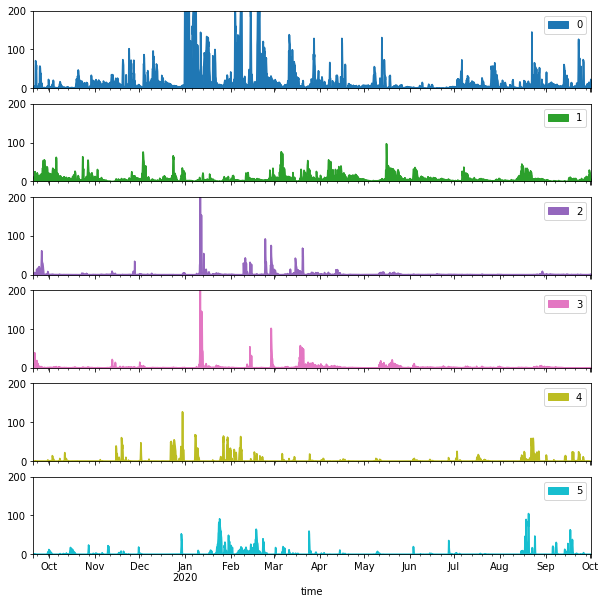

In [204]:
eight_=(ndf/xn * cdf)
eight_.plot.area(figsize=(10,10),subplots=True,sharey=True,ylim=(0,2e2),cmap='tab10')
ax = plt.gca()

<AxesSubplot:>

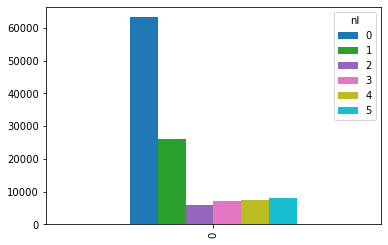

In [205]:
eight_.sum().to_frame().T.plot.bar(cmap='tab10')

In [207]:
eight_.to_csv('../data_out/eight_BC_sources_inverse.csv')

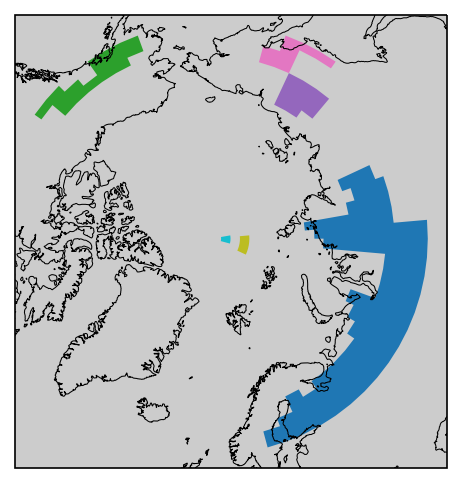

In [208]:
dic = dict(projection=ccrs.Orthographic(0, 90), facecolor=".8")
f, ax = plt.subplots(subplot_kw=dic, sharex=True,sharey=True,dpi=150)
ps1.reset_index().plot(column='index',cmap='tab10',ax=ax,transform=ccrs.Orthographic(0, 90))
ax.coastlines(lw=.5)

(0.0, 90.0)

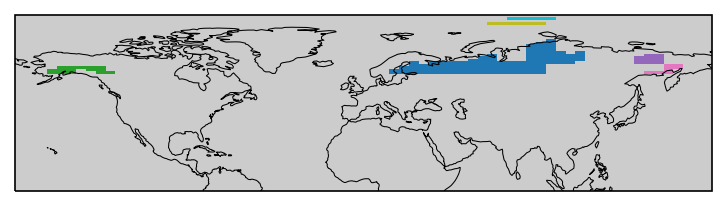

In [209]:
dic = dict(projection=ccrs.PlateCarree(), facecolor=".8")
f, ax = plt.subplots(subplot_kw=dic, sharex=True,sharey=True,dpi=150)
ps1.reset_index().plot(column='index',cmap='tab10',ax=ax,transform=ccrs.Orthographic(0, 90))
ax.coastlines(lw=.5)
ax.set_ylim(0,90)

In [210]:
dss1.to_xarray()[AT][{'time':2}]

<xarray.DataArray 'AIRTRACER' (lon: 32, lat: 16)>
array([[1.08371722e-04, 1.36693372e-04,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan],
       [1.13848124e-04, 1.18038901e-04, 1.03157370e-04,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan],
       [1.17111129e-04, 1.23705991e-04, 1.27007006e-04, 1.27462859e-04,
        1.38275776e-04,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan],
       [9.68725872e-05, 1.52492212e-04, 1.68134866e-04, 2.07272489e-04,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan],
       [4.93140869e-05, 1.05575491e-04, 1.75402427e-04, 1.94428241e-04,
        1.94960172e-04,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan],
...
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan],
       [           nan,            nan, 1.01525307e-04,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan],
       [           nan, 3.84267187e-05, 3.48547146e-05,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan],
       [1.36702647e-05, 1.98245962e-05, 2.88337669e-05,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan],
       [2.83440677e-05,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan]],
      dtype=float32)
Coordinates:
  * lon      (lon) float64 17.5 22.5 27.5 32.5 37.5 ... 217.5 222.5 227.5 232.5
  * lat      (lat) float64 60.62 61.88 63.12 64.38 ... 73.12 74.38 75.62 76.88
    time     datetime64[ns] 2019-09-20T15:00:00

In [242]:
#convert to mrakdown
!jupyter-nbconvert --to markdown z030_inverse_modeling_time_series.ipynb

[NbConvertApp] Converting notebook z030_inverse_modeling_time_series.ipynb to markdown
[NbConvertApp] Support files will be in z030_inverse_modeling_time_series_files/
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inv